[INFO] Fetching CSRF token and logging in...
[INFO] Logged in successfully.
[DEBUG] User Input: ( {cash} ( latest rsi( 14 ) > latest sma( latest rsi( 14 ) , 14 ) and latest rsi( 14 ) > latest sma( latest rsi( 14 ) , 14 ) and 1 day ago  rsi( 14 ) <= 1 day ago  sma( latest rsi( 14 ) , 14 ) and latest rsi( 14 ) > 30 and 1 day ago  rsi( 14 ) <= 30 and market cap > 5000 ) )
[INFO] Using provided scan clause.
[INFO] Fetching backtest results from Chartink...
[INFO] Retrieved 546 stock entries from Chartink.
[INFO] Data cached to chartink_backtest_results.csv.
[INFO] Fetching data for APLLTD.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for IPCALAB.NS from 2024-06-28 00:00:00...
[INFO] Fetching data for RHIM.NS from 2024-07-15 00:00:00...
[INFO] Fetching data for RESPONIND.NS from 2024-07-22 00:00:00...
[INFO] Fetching data for TATASTEEL.NS from 2024-07-26 00:00:00...
[INFO] Fetching data for SKFINDIA.NS from 2024-07-31 00:00:00...
[INFO] Fetching data for GRAPHITE.NS from 2024-08-06 00

C:\Users\CSP\AppData\Local\Temp\ipykernel_8804\1300555038.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
C:\Users\CSP\AppData\Local\Temp\ipykernel_8804\1300555038.py:270: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
C:\Users\CSP\AppData\Local\Temp\ipykernel_8804\1300555038.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')


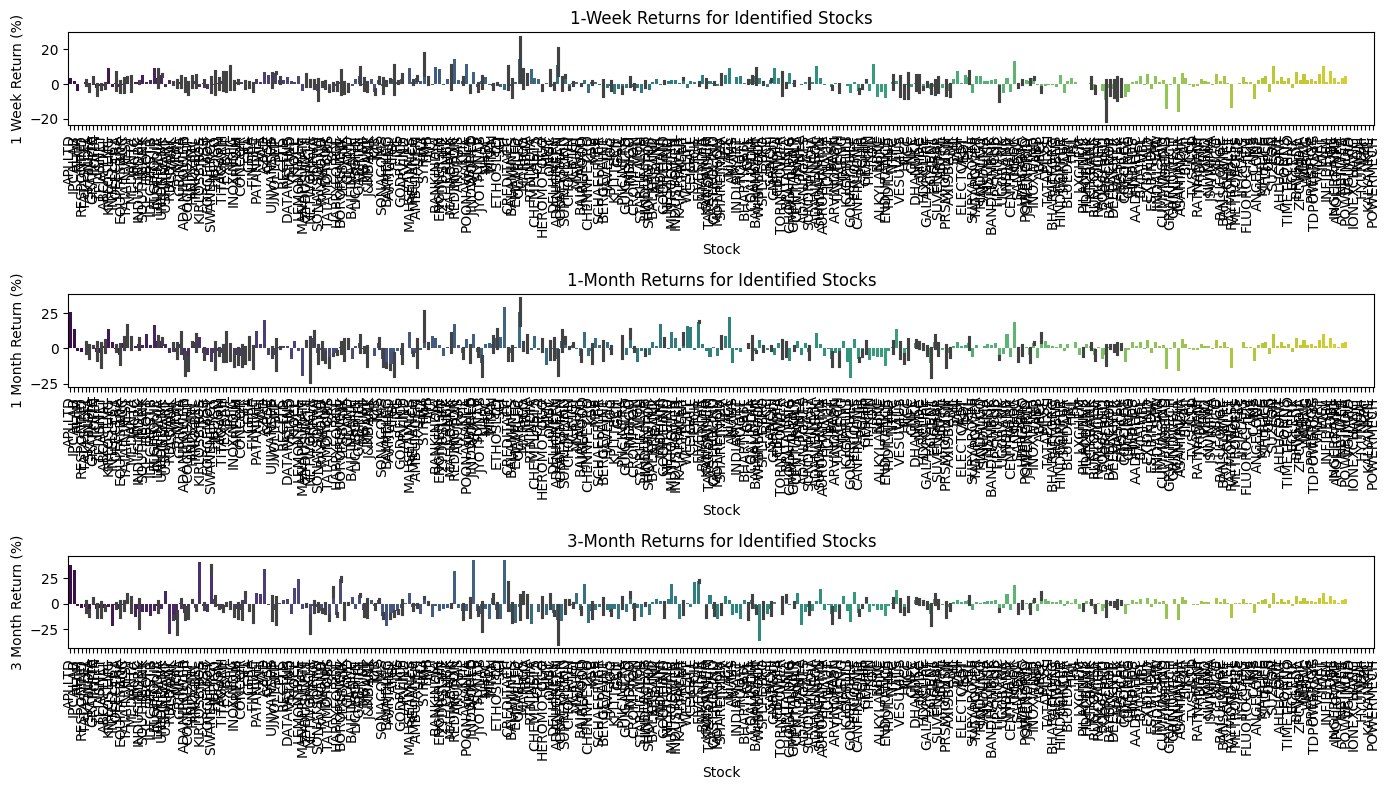

In [1]:
import os
import time
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
CACHE_FILE = 'chartink_backtest_results.csv'
LOGIN_URL = 'https://chartink.com/login'
BACKTEST_URL = 'https://chartink.com/backtest/process'
SCANNER_FETCH_URL = "https://chartink.com/screener/process"

def get_next_business_day(date):
    """
    Returns the next business day if the given date falls on a weekend or holiday.
    """
    while True:
        date += timedelta(days=1)
        if date.weekday() < 5:  # Monday to Friday
            return date


def get_chartink_clause(scanner_input, session):
    """Fetches the scanner clause by making an AJAX request."""

    print(f"[DEBUG] User Input: {scanner_input}")  # Debugging: Print user input

    if "chartink.com/screener/" in scanner_input:
        print("[INFO] Fetching scanner clause from URL...")

        try:
            # Extract scanner name from URL
            scanner_name = scanner_input.split("/")[-1]
            print(f"[DEBUG] Scanner Name: {scanner_name}")  # Debugging: Print scanner name

            # Fetch CSRF token
            login_page = session.get(LOGIN_URL)
            soup = bs(login_page.text, 'html.parser')
            csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']

            if not csrf_token:
                print("[ERROR] CSRF token not found. Exiting...")
                return None

            # Make the AJAX request with CSRF token
            headers = {
                "x-csrf-token": csrf_token,
                "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
            }
            payload = {"scan_clause": "", "screener_name": scanner_name}
            response = session.post(SCANNER_FETCH_URL, headers=headers, data=payload)

            if response.status_code != 200:
                print(f"[ERROR] Failed to fetch scanner data. Status: {response.status_code}")
                print(f"[DEBUG] Response Text: {response.text}")  # Debugging: Print response text
                return None

            # Extract the scan_clause from response JSON
            data = response.json()
            print(f"[DEBUG] Response JSON: {data}")  # Debugging: Print the entire response JSON

            if "scan_clause" in data:
                clause = data["scan_clause"].strip()
                print("[INFO] Scanner clause extracted successfully.")
                return clause
            elif "scan_error" in data:
                print(f"[ERROR] Server returned an error: {data['scan_error']}")
                return None
            else:
                print("[ERROR] Scanner clause not found in response.")
                return None

        except requests.RequestException as e:
            print(f"[ERROR] Request failed: {e}")
            return None

    else:
        print("[INFO] Using provided scan clause.")
        return scanner_input  # Return as-is if it's not a URL


def fetch_csrf_token_and_login():
    """Fetches CSRF token and logs into Chartink."""
    print("[INFO] Fetching CSRF token and logging in...")

    session = requests.Session()
    login_page = session.get(LOGIN_URL)
    
    if login_page.status_code != 200:
        print(f"[ERROR] Failed to fetch login page. Status: {login_page.status_code}")
        return None
    
    soup = bs(login_page.text, 'html.parser')
    csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']
    
    if not csrf_token:
        print("[ERROR] CSRF token not found. Exiting...")
        return None
    
    login_payload = {
        "email": "asagallip@gmail.com",  # Replace with your email
        "password": "Trade@2021",  # Replace with your password
        "_token": csrf_token
    }

    login_response = session.post(LOGIN_URL, data=login_payload)
    
    if login_response.status_code != 200:
        print(f"[ERROR] Failed to log in. Status: {login_response.status_code}")
        return None

    print("[INFO] Logged in successfully.")
    return session, csrf_token


def fetch_chartink_results(session, csrf_token, scan_clause):
    """Fetches backtest results from Chartink."""
    print("[INFO] Fetching backtest results from Chartink...")
    
    headers = {
        "x-csrf-token": csrf_token,
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
    }

    payload = {"scan_clause": scan_clause}
    
    response = session.post(BACKTEST_URL, headers=headers, data=payload)
    
    if response.status_code != 200:
        print(f"[ERROR] Failed to fetch data. Status: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    
    if "metaData" not in data or "aggregatedStockList" not in data:
        print("[ERROR] Invalid response format. Exiting...")
        return pd.DataFrame()
    
    dates = data["metaData"][0]["tradeTimes"]
    stocks = data["aggregatedStockList"]

    results = []
    for i, trade_date in enumerate(dates):
        entry_date = datetime.fromtimestamp(trade_date / 1000).strftime("%Y-%m-%d")
        if stocks[i]:
            for j in range(0, len(stocks[i]), 3):
                results.append({"Date": entry_date, "Stock": stocks[i][j]})

    print(f"[INFO] Retrieved {len(results)} stock entries from Chartink.")
    return pd.DataFrame(results)


def cache_data(df):
    df.to_csv(CACHE_FILE, index=False)
    print(f"[INFO] Data cached to {CACHE_FILE}.")


def load_cached_data():
    if os.path.exists(CACHE_FILE):
        print("[INFO] Loading data from cache...")
        return pd.read_csv(CACHE_FILE)
    return None


def validate_date_format(df):
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df.dropna(subset=["Date"], inplace=True)
    return df


def calculate_returns(df):
    """
    Calculate returns for each stock and include full week's closing prices,
    1-month closing price, and 3-month closing price.
    """
    results = []
    
    for index, row in df.iterrows():
        stock = row["Stock"]
        date = pd.to_datetime(row["Date"])

        ticker_symbol = f"{stock}.NS"  

        try:
            print(f"[INFO] Fetching data for {ticker_symbol} from {date}...")

            # Fetch data for 1 week
            week_end_date = date + timedelta(days=6)
            week_end_date = get_next_business_day(week_end_date) if week_end_date.weekday() >= 5 else week_end_date
            ticker = yf.Ticker(ticker_symbol)
            hist = ticker.history(start=date, end=week_end_date)

            if hist.empty:
                print(f"[WARNING] No data found for {ticker_symbol} on {date}. Skipping...")
                continue

            # Fetch data for 1 month
            month_end_date = date + timedelta(days=30)
            month_end_date = get_next_business_day(month_end_date) if month_end_date.weekday() >= 5 else month_end_date
            hist_month = ticker.history(start=date, end=month_end_date)

            # Fetch data for 3 months
            three_month_end_date = date + timedelta(days=90)
            three_month_end_date = get_next_business_day(three_month_end_date) if three_month_end_date.weekday() >= 5 else three_month_end_date
            hist_three_month = ticker.history(start=date, end=three_month_end_date)

            # Extract prices
            identified_price = hist.iloc[0]['Close']
            week_prices = hist['Close'].to_dict()
            month_price = hist_month.iloc[-1]['Close'] if not hist_month.empty else None
            three_month_price = hist_three_month.iloc[-1]['Close'] if not hist_three_month.empty else None

            # Calculate returns
            week_return = ((hist.iloc[-1]['Close'] - identified_price) / identified_price * 100) if not hist.empty else None
            month_return = ((month_price - identified_price) / identified_price * 100) if month_price else None
            three_month_return = ((three_month_price - identified_price) / identified_price * 100) if three_month_price else None

            # Store results
            results.append({
                'Stock': stock,
                'Date': date,
                'Identified Price': identified_price,
                **{f"Week Day {i+1} Close": week_prices.get(date + timedelta(days=i), None) for i in range(7)},  # Full week prices
                '1 Month Close Price': month_price,
                '3 Month Close Price': three_month_price,
                '1 Week Return (%)': week_return,
                '1 Month Return (%)': month_return,
                '3 Month Return (%)': three_month_return
            })

            time.sleep(1)  # Avoid rate limiting

        except Exception as e:
            print(f"[ERROR] Error processing {stock}: {e}")
            continue

    return pd.DataFrame(results)


def generate_report(df):
    """
    Generates a report, saves it to a CSV file, and plots the results.
    """
    if df.empty:
        print("[ERROR] No data to generate a report.")
        return

    print("\n[INFO] Backtest Report:")
    print(df)

    # Save all columns to CSV
    df.to_csv("backtest_results.csv", index=False)
    print("[INFO] Results saved to 'backtest_results.csv'.")

    # Plot 1-week, 1-month, and 3-month returns
    plt.figure(figsize=(14, 8))

    # Plot 1-Week Return
    plt.subplot(3, 1, 1)
    sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
    plt.title('1-Week Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 1-Month Return
    plt.subplot(3, 1, 2)
    sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
    plt.title('1-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 3-Month Return
    plt.subplot(3, 1, 3)
    sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')
    plt.title('3-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


def main():
    scanner_input = input("Enter Chartink scanner URL or clause: ").strip()
    
    session_data = fetch_csrf_token_and_login()
    if not session_data:
        return

    session, csrf_token = session_data
    scan_clause = get_chartink_clause(scanner_input, session)

    if not scan_clause:
        print("[ERROR] Failed to fetch scan clause from URL.")
        scan_clause = input("Please manually enter the scan clause: ").strip()
        if not scan_clause:
            print("[ERROR] No scan clause provided. Exiting...")
            return

    use_chartink = input("Fetch fresh data from Chartink? (yes/no): ").strip().lower()
    
    if use_chartink == "yes":
        df = fetch_chartink_results(session, csrf_token, scan_clause)
        df = validate_date_format(df)
        cache_data(df)

    else:
        df = load_cached_data()
        if df is None:
            print("[INFO] No cache found. Fetching fresh data...")
            df = fetch_chartink_results(session, csrf_token, scan_clause)
            df = validate_date_format(df)
            cache_data(df)

    # Calculate returns and generate report
    results_df = calculate_returns(df)
    generate_report(results_df)  # Pass the results to generate_report


if __name__ == "__main__":
    main()

[INFO] Fetching CSRF token and logging in...
[INFO] Logged in successfully.
[DEBUG] User Input: ( {cash} ( ( {cash} ( latest rsi( 14 ) > 45 and weekly rsi( 14 ) > 60 and monthly rsi( 14 ) > 60 and monthly wma( monthly close , 30 ) > 60 and latest close > latest open and latest ema( close,15 ) > latest ema( close,50 ) and 1 day ago  ema( close,15 )<= 1 day ago  ema( close,50 ) ) ) ) )
[INFO] Using provided scan clause.
[INFO] Fetching backtest results from Chartink...
[INFO] Retrieved 257 stock entries from Chartink.
[INFO] Data cached to chartink_backtest_results.csv.
[INFO] Fetching data for KSL.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for THOMASCOTT.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for NAVKARCORP.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for TTL.NS from 2024-06-24 00:00:00...
[INFO] Fetching data for SASKEN.NS from 2024-06-24 00:00:00...
[INFO] Fetching data for NBIFIN.NS from 2024-06-25 00:00:00...
[INFO] Fetching data for NEULANDLAB.NS from 2

$BANKNIFTY.NS: possibly delisted; no timezone found


[WARNING] No data found for BANKNIFTY.NS on 2024-08-27 00:00:00. Skipping...
[INFO] Fetching data for TEJASNET.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for GOODLUCK.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for ZUARIIND.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for MODIRUBBER.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for KEC.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for SUNDARMFIN.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for VSTTILLERS.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for HEROMOTOCO.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for PIDILITIND.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for AEGISLOG.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for ASAHIINDIA.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for FLUOROCHEM.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for BRIGADE.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for ZFCVINDIA.NS from 2024-09-09 00:00:00...
[INF

$NIFTYMETAL.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTYMETAL.NS on 2024-09-24 00:00:00. Skipping...
[INFO] Fetching data for VIDHIING.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for NATIONALUM.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for SMARTLINK.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for BFUTILITIE.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for MARUTI.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for GODREJPROP.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for HNGSNGBEES.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for CPSEETF.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for SIEMENS.NS from 2024-09-27 00:00:00...
[INFO] Fetching data for IOC.NS from 2024-09-27 00:00:00...
[INFO] Fetching data for FEDERALBNK.NS from 2024-09-30 00:00:00...
[INFO] Fetching data for STYRENIX.NS from 2024-10-01 00:00:00...
[INFO] Fetching data for EIMCOELECO.NS from 2024-10-01 00:00:00...
[INFO] Fetching data for HERCULES.NS from 2024-10-08 00:00:00...
[INFO] F

$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-02 00:00:00 -> 2024-12-09 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733077800, endDate = 1733682600")


[WARNING] No data found for HBLENGINE.NS on 2024-12-02 00:00:00. Skipping...
[INFO] Fetching data for WANBURY.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHAPURMIN.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for SETFNIFBK.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DSSL.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHOKA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for RPPINFRA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DIACABS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for ULTRACEMCO.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for NITINSPIN.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for LTFOODS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for BANARISUG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for INDIAGLYCO.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for HEG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for GOLDIAM.NS from 2024-12-04 00:00:00...
[INFO] Fetching dat

$CNXSMALLCAP.NS: possibly delisted; no timezone found


[WARNING] No data found for CNXSMALLCAP.NS on 2024-12-05 00:00:00. Skipping...
[INFO] Fetching data for WELENT.NS from 2024-12-05 00:00:00...
[INFO] Fetching data for VEDL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for NIFTYCONSURDURBL.NS from 2024-12-06 00:00:00...


$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTYCONSURDURBL.NS on 2024-12-06 00:00:00. Skipping...
[INFO] Fetching data for GODREJAGRO.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ADSL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ROTO.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for SUMIT.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for WEL.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for LUMAXTECH.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for RELIGARE.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for MAXIND.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for HARRMALAYA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for GABRIEL.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for MHLXMIRU.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for ZOTA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for IIFLCAPS.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for

$NIFTY50VALUE20.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTY50VALUE20.NS on 2024-12-11 00:00:00. Skipping...
[INFO] Fetching data for CHEMFAB.NS from 2024-12-11 00:00:00...
[INFO] Fetching data for HINDCOMPOS.NS from 2024-12-12 00:00:00...
[INFO] Fetching data for CENTUM.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STARCEMENT.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for BHARTIARTL.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STOVEKRAFT.NS from 2024-12-16 00:00:00...
[INFO] Fetching data for LUPIN.NS from 2024-12-23 00:00:00...
[INFO] Fetching data for POWERINDIA.NS from 2024-12-24 00:00:00...


$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2025-01-01 00:00:00)


[INFO] Fetching data for CNXPHARMA.NS from 2024-12-26 00:00:00...
[WARNING] No data found for CNXPHARMA.NS on 2024-12-26 00:00:00. Skipping...
[INFO] Fetching data for SUNPHARMA.NS from 2024-12-26 00:00:00...
[INFO] Fetching data for WORTH.NS from 2024-12-30 00:00:00...
[INFO] Fetching data for APOLLO.NS from 2024-12-31 00:00:00...
[INFO] Fetching data for KAUSHALYA.NS from 2025-01-01 00:00:00...
[INFO] Fetching data for EICHERMOT.NS from 2025-01-02 00:00:00...
[INFO] Fetching data for SRF.NS from 2025-01-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for CUBEXTUB.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for AYMSYNTEX.NS from 2025-01-20 00:00:00...
[INFO] Fetching data for KHAITANLTD.NS from 2025-01-22 00:00:00...
[INFO] Fetching data for MPSLTD.NS from 2025-01-24 00:00:00...
[INFO] Fetching data for AMIORG.NS from 2025-01-30 00:00:00...
[INFO] Fetching data for DEEPINDS.NS from 2025-01-31 00:00:00...
[INFO] Fetching data

C:\Users\CSP\AppData\Local\Temp\ipykernel_10064\2917292025.py:279: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
C:\Users\CSP\AppData\Local\Temp\ipykernel_10064\2917292025.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
C:\Users\CSP\AppData\Local\Temp\ipykernel_10064\2917292025.py:291: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')


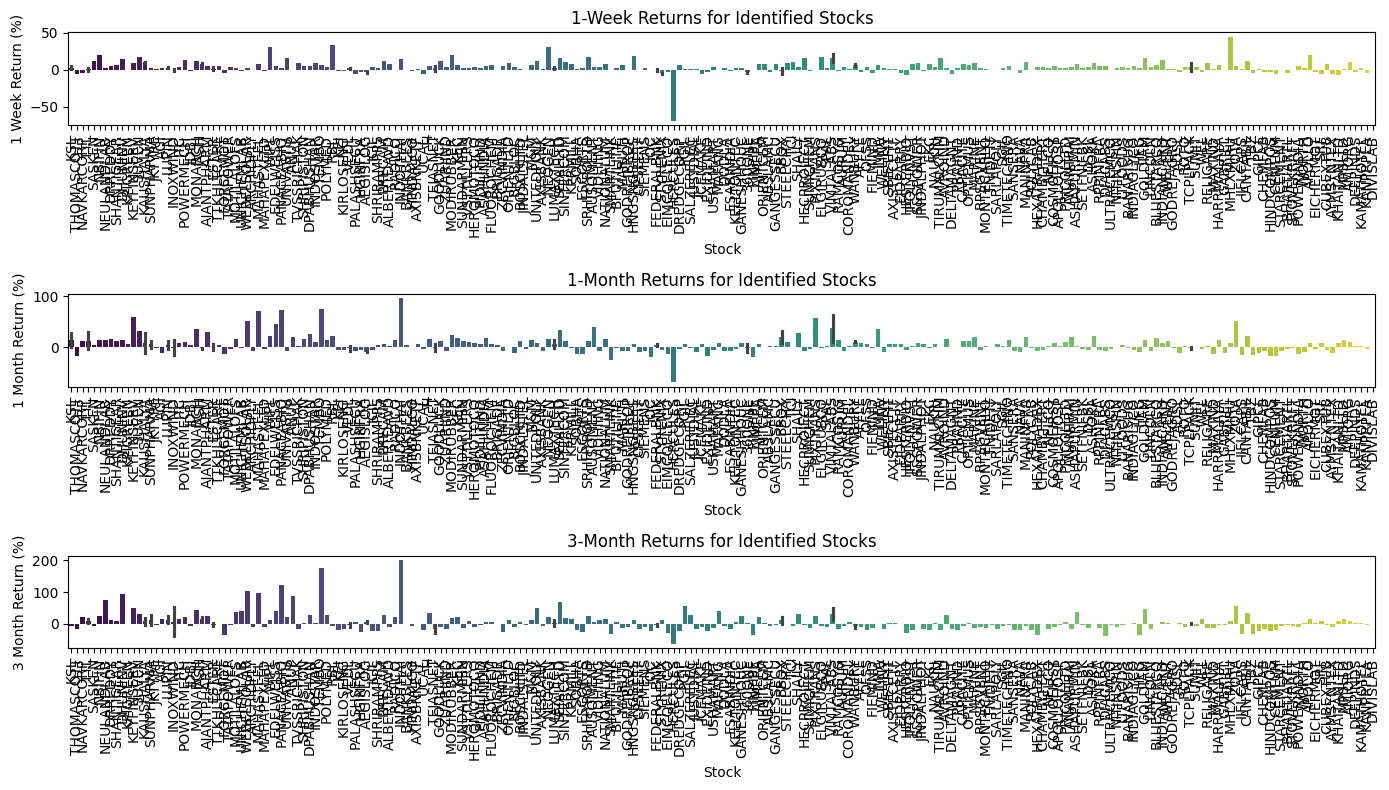

In [1]:
import os
import time
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns


# Constants
CACHE_FILE = 'chartink_backtest_results.csv'
LOGIN_URL = 'https://chartink.com/login'
BACKTEST_URL = 'https://chartink.com/backtest/process'
SCANNER_FETCH_URL = "https://chartink.com/screener/process"

def get_next_business_day(date):
    """
    Returns the next business day if the given date falls on a weekend or holiday.
    """
    while True:
        date += timedelta(days=1)
        if date.weekday() < 5:  # Monday to Friday
            return date


def get_chartink_clause(scanner_input, session):
    """Fetches the scanner clause by making an AJAX request."""

    print(f"[DEBUG] User Input: {scanner_input}")  # Debugging: Print user input

    if "chartink.com/screener/" in scanner_input:
        print("[INFO] Fetching scanner clause from URL...")

        try:
            # Extract scanner name from URL
            scanner_name = scanner_input.split("/")[-1]
            print(f"[DEBUG] Scanner Name: {scanner_name}")  # Debugging: Print scanner name

            # Fetch CSRF token
            login_page = session.get(LOGIN_URL)
            soup = bs(login_page.text, 'html.parser')
            csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']

            if not csrf_token:
                print("[ERROR] CSRF token not found. Exiting...")
                return None

            # Make the AJAX request with CSRF token
            headers = {
                "x-csrf-token": csrf_token,
                "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
            }
            payload = {"scan_clause": "", "screener_name": scanner_name}
            response = session.post(SCANNER_FETCH_URL, headers=headers, data=payload)

            if response.status_code != 200:
                print(f"[ERROR] Failed to fetch scanner data. Status: {response.status_code}")
                print(f"[DEBUG] Response Text: {response.text}")  # Debugging: Print response text
                return None

            # Extract the scan_clause from response JSON
            data = response.json()
            print(f"[DEBUG] Response JSON: {data}")  # Debugging: Print the entire response JSON

            if "scan_clause" in data:
                clause = data["scan_clause"].strip()
                print("[INFO] Scanner clause extracted successfully.")
                return clause
            elif "scan_error" in data:
                print(f"[ERROR] Server returned an error: {data['scan_error']}")
                return None
            else:
                print("[ERROR] Scanner clause not found in response.")
                return None

        except requests.RequestException as e:
            print(f"[ERROR] Request failed: {e}")
            return None

    else:
        print("[INFO] Using provided scan clause.")
        return scanner_input  # Return as-is if it's not a URL


def fetch_csrf_token_and_login():
    """Fetches CSRF token and logs into Chartink."""
    print("[INFO] Fetching CSRF token and logging in...")

    session = requests.Session()
    login_page = session.get(LOGIN_URL)
    
    if login_page.status_code != 200:
        print(f"[ERROR] Failed to fetch login page. Status: {login_page.status_code}")
        return None
    
    soup = bs(login_page.text, 'html.parser')
    csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']
    
    if not csrf_token:
        print("[ERROR] CSRF token not found. Exiting...")
        return None
    
    login_payload = {
        "email": "asagallip@gmail.com",  # Replace with your email
        "password": "Trade@2021",  # Replace with your password
        "_token": csrf_token
    }

    login_response = session.post(LOGIN_URL, data=login_payload)
    
    if login_response.status_code != 200:
        print(f"[ERROR] Failed to log in. Status: {login_response.status_code}")
        return None

    print("[INFO] Logged in successfully.")
    return session, csrf_token


def fetch_chartink_results(session, csrf_token, scan_clause):
    """Fetches backtest results from Chartink."""
    print("[INFO] Fetching backtest results from Chartink...")
    
    headers = {
        "x-csrf-token": csrf_token,
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
    }

    payload = {"scan_clause": scan_clause}
    
    response = session.post(BACKTEST_URL, headers=headers, data=payload)
    
    if response.status_code != 200:
        print(f"[ERROR] Failed to fetch data. Status: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    
    if "metaData" not in data or "aggregatedStockList" not in data:
        print("[ERROR] Invalid response format. Exiting...")
        return pd.DataFrame()
    
    dates = data["metaData"][0]["tradeTimes"]
    stocks = data["aggregatedStockList"]

    results = []
    for i, trade_date in enumerate(dates):
        entry_date = datetime.fromtimestamp(trade_date / 1000).strftime("%Y-%m-%d")
        if stocks[i]:
            for j in range(0, len(stocks[i]), 3):
                results.append({"Date": entry_date, "Stock": stocks[i][j]})

    print(f"[INFO] Retrieved {len(results)} stock entries from Chartink.")
    return pd.DataFrame(results)


def cache_data(df):
    df.to_csv(CACHE_FILE, index=False)
    print(f"[INFO] Data cached to {CACHE_FILE}.")


def load_cached_data():
    if os.path.exists(CACHE_FILE):
        print("[INFO] Loading data from cache...")
        return pd.read_csv(CACHE_FILE)
    return None


def validate_date_format(df):
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df.dropna(subset=["Date"], inplace=True)
    return df


def calculate_returns(df):
    """
    Calculate returns for each stock and include full week's closing prices,
    1-month closing price, and 3-month closing price.
    """
    results = []
    
    for index, row in df.iterrows():
        stock = row["Stock"]
        date = pd.to_datetime(row["Date"])

        ticker_symbol = f"{stock}.NS"  

        try:
            print(f"[INFO] Fetching data for {ticker_symbol} from {date}...")

            # Fetch data for 1 week
            week_end_date = date + timedelta(days=6)
            week_end_date = get_next_business_day(week_end_date) if week_end_date.weekday() >= 5 else week_end_date
            ticker = yf.Ticker(ticker_symbol)
            hist = ticker.history(start=date, end=week_end_date)

            if hist.empty:
                print(f"[WARNING] No data found for {ticker_symbol} on {date}. Skipping...")
                continue

            # Fetch data for 1 month
            month_end_date = date + timedelta(days=30)
            month_end_date = get_next_business_day(month_end_date) if month_end_date.weekday() >= 5 else month_end_date
            hist_month = ticker.history(start=date, end=month_end_date)

            # Fetch data for 3 months
            three_month_end_date = date + timedelta(days=90)
            three_month_end_date = get_next_business_day(three_month_end_date) if three_month_end_date.weekday() >= 5 else three_month_end_date
            hist_three_month = ticker.history(start=date, end=three_month_end_date)

            # Extract prices
            identified_price = hist.iloc[0]['Close']
            week_prices = hist['Close'].to_dict()
            month_price = hist_month.iloc[-1]['Close'] if not hist_month.empty else None
            three_month_price = hist_three_month.iloc[-1]['Close'] if not hist_three_month.empty else None

            # Calculate returns
            week_return = ((hist.iloc[-1]['Close'] - identified_price) / identified_price * 100) if not hist.empty else None
            month_return = ((month_price - identified_price) / identified_price * 100) if month_price else None
            three_month_return = ((three_month_price - identified_price) / identified_price * 100) if three_month_price else None

            # Store results
            results.append({
                'Stock': stock,
                'Date': date,
                'Identified Price': identified_price,
                **{f"Week Day {i+1} Close": week_prices.get(date + timedelta(days=i), None) for i in range(7)},  # Full week prices
                '1 Month Close Price': month_price,
                '3 Month Close Price': three_month_price,
                '1 Week Return (%)': week_return,
                '1 Month Return (%)': month_return,
                '3 Month Return (%)': three_month_return
            })

            time.sleep(1)  # Avoid rate limiting

        except Exception as e:
            print(f"[ERROR] Error processing {stock}: {e}")
            continue

    return pd.DataFrame(results)


def generate_report(df):
    """
    Generates a report, saves it to a CSV file, and plots the results.
    """
    if df.empty:
        print("[ERROR] No data to generate a report.")
        return

    print("\n[INFO] Backtest Report:")
    print(df)

    # Get current date for filenames
    current_date = datetime.now().strftime("%Y-%m-%d")
    csv_filename = f"bactestresult_{current_date}.csv"
    json_filename = f"bactestresult_{current_date}.json"


    # # Save all columns to CSV
    # df.to_csv("backtest_results.csv", index=False)
    # print("[INFO] Results saved to 'backtest_results.csv'.")

    # Save all columns to CSV
    df.to_csv(csv_filename, index=False)
    print(f"[INFO] Results saved to '{csv_filename}'.")    

    # Convert to JSON and save
    df.to_json(json_filename, orient='records', date_format='iso')
    print(f"[INFO] JSON results saved to '{json_filename}'.")

    # Plot 1-week, 1-month, and 3-month returns
    plt.figure(figsize=(14, 8))

    # Plot 1-Week Return
    plt.subplot(3, 1, 1)
    sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
    plt.title('1-Week Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 1-Month Return
    plt.subplot(3, 1, 2)
    sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
    plt.title('1-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 3-Month Return
    plt.subplot(3, 1, 3)
    sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')
    plt.title('3-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


def main():
    scanner_input = input("Enter Chartink scanner URL or clause: ").strip()
    
    session_data = fetch_csrf_token_and_login()
    if not session_data:
        return

    session, csrf_token = session_data
    scan_clause = get_chartink_clause(scanner_input, session)

    if not scan_clause:
        print("[ERROR] Failed to fetch scan clause from URL.")
        scan_clause = input("Please manually enter the scan clause: ").strip()
        if not scan_clause:
            print("[ERROR] No scan clause provided. Exiting...")
            return

    use_chartink = input("Fetch fresh data from Chartink? (yes/no): ").strip().lower()
    
    if use_chartink == "yes":
        df = fetch_chartink_results(session, csrf_token, scan_clause)
        df = validate_date_format(df)
        cache_data(df)

    else:
        df = load_cached_data()
        if df is None:
            print("[INFO] No cache found. Fetching fresh data...")
            df = fetch_chartink_results(session, csrf_token, scan_clause)
            df = validate_date_format(df)
            cache_data(df)

    # Calculate returns and generate report
    results_df = calculate_returns(df)
    generate_report(results_df)  # Pass the results to generate_report


if __name__ == "__main__":
    main()

In [2]:
import os
import time
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import json  # For JSON file handling

# Constants
CACHE_FILE = 'chartink_backtest_results.csv'
LOGIN_URL = 'https://chartink.com/login'
BACKTEST_URL = 'https://chartink.com/backtest/process'
SCANNER_FETCH_URL = "https://chartink.com/screener/process"

def get_next_business_day(date):
    """
    Returns the next business day if the given date falls on a weekend or holiday.
    """
    while True:
        date += timedelta(days=1)
        if date.weekday() < 5:  # Monday to Friday
            return date

def get_chartink_clause(scanner_input, session):
    """Fetches the scanner clause by making an AJAX request."""
    print(f"[DEBUG] User Input: {scanner_input}")  # Debugging: Print user input

    # Normalize the scan clause by adding {cash} if it's missing
    if not scanner_input.strip().startswith("{"):
        scanner_input = "{cash} " + scanner_input.strip()
        print(f"[INFO] Normalized scan clause: {scanner_input}")

    if "chartink.com/screener/" in scanner_input:
        print("[INFO] Fetching scanner clause from URL...")

        try:
            # Extract scanner name from URL
            scanner_name = scanner_input.split("/")[-1]
            print(f"[DEBUG] Scanner Name: {scanner_name}")  # Debugging: Print scanner name

            # Fetch CSRF token
            login_page = session.get(LOGIN_URL)
            soup = bs(login_page.text, 'html.parser')
            csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']

            if not csrf_token:
                print("[ERROR] CSRF token not found. Exiting...")
                return None

            # Make the AJAX request with CSRF token
            headers = {
                "x-csrf-token": csrf_token,
                "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
            }
            payload = {"scan_clause": "", "screener_name": scanner_name}
            response = session.post(SCANNER_FETCH_URL, headers=headers, data=payload)

            if response.status_code != 200:
                print(f"[ERROR] Failed to fetch scanner data. Status: {response.status_code}")
                print(f"[DEBUG] Response Text: {response.text}")  # Debugging: Print response text
                return None

            # Extract the scan_clause from response JSON
            data = response.json()
            print(f"[DEBUG] Response JSON: {data}")  # Debugging: Print the entire response JSON

            if "scan_clause" in data:
                clause = data["scan_clause"].strip()
                print("[INFO] Scanner clause extracted successfully.")
                return clause
            elif "scan_error" in data:
                print(f"[ERROR] Server returned an error: {data['scan_error']}")
                return None
            else:
                print("[ERROR] Scanner clause not found in response.")
                return None

        except requests.RequestException as e:
            print(f"[ERROR] Request failed: {e}")
            return None

    else:
        print("[INFO] Using provided scan clause.")
        return scanner_input  # Return as-is if it's not a URL

def fetch_csrf_token_and_login():
    """Fetches CSRF token and logs into Chartink."""
    print("[INFO] Fetching CSRF token and logging in...")

    session = requests.Session()
    login_page = session.get(LOGIN_URL)

    if login_page.status_code != 200:
        print(f"[ERROR] Failed to fetch login page. Status: {login_page.status_code}")
        return None

    soup = bs(login_page.text, 'html.parser')
    csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']

    if not csrf_token:
        print("[ERROR] CSRF token not found. Exiting...")
        return None

    login_payload = {
        "email": "asagallip@gmail.com",  # Replace with your email
        "password": "Trade@2021",  # Replace with your password
        "_token": csrf_token
    }

    login_response = session.post(LOGIN_URL, data=login_payload)

    if login_response.status_code != 200:
        print(f"[ERROR] Failed to log in. Status: {login_response.status_code}")
        return None

    print("[INFO] Logged in successfully.")
    return session, csrf_token

def fetch_chartink_results(session, csrf_token, scan_clause):
    """Fetches backtest results from Chartink."""
    print("[INFO] Fetching backtest results from Chartink...")

    headers = {
        "x-csrf-token": csrf_token,
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
    }

    payload = {"scan_clause": scan_clause}

    response = session.post(BACKTEST_URL, headers=headers, data=payload)

    if response.status_code != 200:
        print(f"[ERROR] Failed to fetch data. Status: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    print(f"[DEBUG] Backtest Response: {data}")  # Debugging: Print the full response

    results = []

    # Handle response from saved screener URL
    if "metaData" in data and "aggregatedStockList" in data:
        dates = data["metaData"][0]["tradeTimes"]
        stocks = data["aggregatedStockList"]

        for i, trade_date in enumerate(dates):
            entry_date = datetime.fromtimestamp(trade_date / 1000).strftime("%Y-%m-%d")
            if stocks[i]:
                for j in range(0, len(stocks[i]), 3):
                    results.append({"Date": entry_date, "Stock": stocks[i][j]})

    # Handle response from direct scan clause (scan token)
    elif "link" in data:
        scan_token = data["link"].split(":")[-1]  # Extract scan token from the link
        print(f"[INFO] Fetching results using scan token: {scan_token}")

        # Fetch results using the scan token
        fetch_url = f"https://chartink.com/screener/process?scan_token={scan_token}"
        fetch_response = session.post(fetch_url, headers=headers)

        if fetch_response.status_code != 200:
            print(f"[ERROR] Failed to fetch results using scan token. Status: {fetch_response.status_code}")
            return pd.DataFrame()

        fetch_data = fetch_response.json()
        print(f"[DEBUG] Scan Token Response: {fetch_data}")  # Debugging: Print the full response

        if "data" in fetch_data:
            if fetch_data["data"]:  # Check if data is not empty
                for entry in fetch_data["data"]:
                    entry_date = entry.get("date")
                    stock = entry.get("stock")
                    if entry_date and stock:
                        results.append({"Date": entry_date, "Stock": stock})
            else:
                print("[ERROR] No data found in scan token response.")
                return pd.DataFrame()
        else:
            print("[ERROR] Invalid scan token response format.")
            return pd.DataFrame()

    else:
        print("[ERROR] Invalid response format. Exiting...")
        return pd.DataFrame()

    print(f"[INFO] Retrieved {len(results)} stock entries from Chartink.")
    return pd.DataFrame(results)

def cache_data(df):
    df.to_csv(CACHE_FILE, index=False)
    print(f"[INFO] Data cached to {CACHE_FILE}.")

def load_cached_data():
    if os.path.exists(CACHE_FILE):
        print("[INFO] Loading data from cache...")
        return pd.read_csv(CACHE_FILE)
    return None

def validate_date_format(df):
    """
    Validate and convert the 'Date' column to datetime.
    Skip rows with invalid or future dates.
    """
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df.dropna(subset=["Date"], inplace=True)

    # Skip future dates
    current_date = datetime.now()
    df = df[df["Date"] <= current_date]

    return df

def calculate_returns(df):
    """
    Calculate returns for each stock and include full week's closing prices,
    1-month closing price, and 3-month closing price.
    """
    results = []

    for index, row in df.iterrows():
        stock = row["Stock"]
        date = pd.to_datetime(row["Date"])

        # Skip future dates or invalid dates
        if date > datetime.now():
            print(f"[WARNING] Skipping {stock} due to future date: {date}")
            continue

        ticker_symbol = f"{stock}.NS"

        try:
            print(f"[INFO] Fetching data for {ticker_symbol} from {date}...")

            # Fetch data for 1 week
            week_prices = {}
            for i in range(7):
                day_date = date + timedelta(days=i)
                day_date = get_next_business_day(day_date) if day_date.weekday() >= 5 else day_date
                try:
                    hist = yf.Ticker(ticker_symbol).history(start=day_date, end=day_date + timedelta(days=1))
                    if not hist.empty:
                        week_prices[f"Week Day {i+1} Close"] = hist.iloc[0]['Close']
                    else:
                        week_prices[f"Week Day {i+1} Close"] = None
                except Exception as e:
                    print(f"[WARNING] Error fetching data for {ticker_symbol} on {day_date}: {e}")
                    week_prices[f"Week Day {i+1} Close"] = None

            # Fetch data for 1 month
            month_end_date = date + timedelta(days=30)
            month_end_date = get_next_business_day(month_end_date) if month_end_date.weekday() >= 5 else month_end_date
            try:
                hist_month = yf.Ticker(ticker_symbol).history(start=date, end=month_end_date)
                month_price = hist_month.iloc[-1]['Close'] if not hist_month.empty else None
            except Exception as e:
                print(f"[WARNING] Error fetching 1-month data for {ticker_symbol}: {e}")
                month_price = None

            # Fetch data for 3 months
            three_month_end_date = date + timedelta(days=90)
            three_month_end_date = get_next_business_day(three_month_end_date) if three_month_end_date.weekday() >= 5 else three_month_end_date
            try:
                hist_three_month = yf.Ticker(ticker_symbol).history(start=date, end=three_month_end_date)
                three_month_price = hist_three_month.iloc[-1]['Close'] if not hist_three_month.empty else None
            except Exception as e:
                print(f"[WARNING] Error fetching 3-month data for {ticker_symbol}: {e}")
                three_month_price = None

            # Extract identified price
            try:
                hist = yf.Ticker(ticker_symbol).history(start=date, end=date + timedelta(days=1))
                identified_price = hist.iloc[0]['Close'] if not hist.empty else None
            except Exception as e:
                print(f"[WARNING] Error fetching identified price for {ticker_symbol}: {e}")
                identified_price = None

            # Calculate returns
            week_return = ((week_prices["Week Day 7 Close"] - identified_price) / identified_price * 100) if week_prices["Week Day 7 Close"] and identified_price else None
            month_return = ((month_price - identified_price) / identified_price * 100) if month_price and identified_price else None
            three_month_return = ((three_month_price - identified_price) / identified_price * 100) if three_month_price and identified_price else None

            # Store results
            results.append({
                'Stock': stock,
                'Date': date,
                'Identified Price': identified_price,
                **week_prices,  # Full week prices
                '1 Month Close Price': month_price,
                '3 Month Close Price': three_month_price,
                '1 Week Return (%)': week_return,
                '1 Month Return (%)': month_return,
                '3 Month Return (%)': three_month_return
            })

            time.sleep(1)  # Avoid rate limiting

        except Exception as e:
            print(f"[ERROR] Error processing {stock}: {e}")
            continue

    return pd.DataFrame(results)

def save_results_with_date(df):
    """
    Save the results to CSV and JSON files with the current date in the filename.
    """
    current_date = datetime.now().strftime("%Y-%m-%d")
    csv_filename = f"bactestresult_{current_date}.csv"
    json_filename = f"bactestresult_{current_date}.json"

    # Save to CSV
    df.to_csv(csv_filename, index=False)
    print(f"[INFO] Results saved to {csv_filename}.")

    # Save to JSON
    df.to_json(json_filename, orient='records', date_format='iso')
    print(f"[INFO] Results saved to {json_filename}.")

def generate_report(df):
    """
    Generates a report, saves it to a CSV file, and plots the results.
    """
    if df.empty:
        print("[ERROR] No data to generate a report.")
        return

    print("\n[INFO] Backtest Report:")
    print(df)

    # Save results with current date
    save_results_with_date(df)

    # Plot 1-week, 1-month, and 3-month returns
    plt.figure(figsize=(14, 8))

    # Plot 1-Week Return
    plt.subplot(3, 1, 1)
    sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
    plt.title('1-Week Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 1-Month Return
    plt.subplot(3, 1, 2)
    sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
    plt.title('1-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 3-Month Return
    plt.subplot(3, 1, 3)
    sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')
    plt.title('3-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

def main():
    scanner_input = input("Enter Chartink scanner URL or clause: ").strip()

    session_data = fetch_csrf_token_and_login()
    if not session_data:
        return

    session, csrf_token = session_data
    scan_clause = get_chartink_clause(scanner_input, session)

    if not scan_clause:
        print("[ERROR] Failed to fetch scan clause from URL.")
        scan_clause = input("Please manually enter the scan clause: ").strip()
        if not scan_clause:
            print("[ERROR] No scan clause provided. Exiting...")
            return

    use_chartink = input("Fetch fresh data from Chartink? (yes/no): ").strip().lower()

    if use_chartink == "yes":
        df = fetch_chartink_results(session, csrf_token, scan_clause)
        df = validate_date_format(df)
        cache_data(df)

    else:
        df = load_cached_data()
        if df is None:
            print("[INFO] No cache found. Fetching fresh data...")
            df = fetch_chartink_results(session, csrf_token, scan_clause)
            df = validate_date_format(df)
            cache_data(df)

    # Calculate returns and generate report
    results_df = calculate_returns(df)
    generate_report(results_df)  # Pass the results to generate_report

if __name__ == "__main__":
    main()

[INFO] Fetching CSRF token and logging in...
[INFO] Logged in successfully.
[DEBUG] User Input: ( {cash} ( ( {cash} ( latest rsi( 14 ) > 45 and weekly rsi( 14 ) > 60 and monthly rsi( 14 ) > 60 and monthly wma( monthly close , 30 ) > 60 and latest close > latest open and latest ema( close,15 ) > latest ema( close,50 ) and 1 day ago  ema( close,15 )<= 1 day ago  ema( close,50 ) ) ) ) )
[INFO] Normalized scan clause: {cash} ( {cash} ( ( {cash} ( latest rsi( 14 ) > 45 and weekly rsi( 14 ) > 60 and monthly rsi( 14 ) > 60 and monthly wma( monthly close , 30 ) > 60 and latest close > latest open and latest ema( close,15 ) > latest ema( close,50 ) and 1 day ago  ema( close,15 )<= 1 day ago  ema( close,50 ) ) ) ) )
[INFO] Using provided scan clause.
[INFO] Loading data from cache...
[INFO] Fetching data for KSL.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for THOMASCOTT.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for NAVKARCORP.NS from 2024-06-21 00:00:00...
[INFO] Fetching data 

$IDBI.NS: possibly delisted; no price data found  (1d 2024-07-17 00:00:00 -> 2024-07-18 00:00:00)


[INFO] Fetching data for MONARCH.NS from 2024-07-24 00:00:00...
[INFO] Fetching data for JASH.NS from 2024-07-24 00:00:00...
[INFO] Fetching data for AJANTPHARM.NS from 2024-07-25 00:00:00...
[INFO] Fetching data for ESTER.NS from 2024-07-29 00:00:00...
[INFO] Fetching data for TTKHLTCARE.NS from 2024-07-29 00:00:00...
[INFO] Fetching data for FORCEMOT.NS from 2024-07-30 00:00:00...
[INFO] Fetching data for TATAPOWER.NS from 2024-07-30 00:00:00...
[INFO] Fetching data for MOTILALOFS.NS from 2024-07-30 00:00:00...
[INFO] Fetching data for UNICHEMLAB.NS from 2024-07-31 00:00:00...
[INFO] Fetching data for WEBELSOLAR.NS from 2024-07-31 00:00:00...
[INFO] Fetching data for ARCHIDPLY.NS from 2024-08-06 00:00:00...
[INFO] Fetching data for MAHASTEEL.NS from 2024-08-08 00:00:00...
[INFO] Fetching data for MAHAPEXLTD.NS from 2024-08-08 00:00:00...
[INFO] Fetching data for WIPL.NS from 2024-08-08 00:00:00...
[INFO] Fetching data for EDELWEISS.NS from 2024-08-09 00:00:00...


$EDELWEISS.NS: possibly delisted; no price data found  (1d 2024-08-15 00:00:00 -> 2024-08-16 00:00:00)


[INFO] Fetching data for PANACEABIO.NS from 2024-08-12 00:00:00...


$PANACEABIO.NS: possibly delisted; no price data found  (1d 2024-08-15 00:00:00 -> 2024-08-16 00:00:00)


[INFO] Fetching data for UNIVASTU.NS from 2024-08-13 00:00:00...


$UNIVASTU.NS: possibly delisted; no price data found  (1d 2024-08-15 00:00:00 -> 2024-08-16 00:00:00)


[INFO] Fetching data for ANUP.NS from 2024-08-13 00:00:00...


$ANUP.NS: possibly delisted; no price data found  (1d 2024-08-15 00:00:00 -> 2024-08-16 00:00:00)


[INFO] Fetching data for TVSSRICHAK.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for SHRIPISTON.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for DPABHUSHAN.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for INDOSTAR.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for TEMBO.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for POLYMED.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for RBL.NS from 2024-08-19 00:00:00...
[INFO] Fetching data for KEI.NS from 2024-08-20 00:00:00...
[INFO] Fetching data for KIRLOSENG.NS from 2024-08-20 00:00:00...
[INFO] Fetching data for VEDL.NS from 2024-08-21 00:00:00...
[INFO] Fetching data for PALASHSECU.NS from 2024-08-21 00:00:00...
[INFO] Fetching data for HGINFRA.NS from 2024-08-21 00:00:00...
[INFO] Fetching data for AEGISLOG.NS from 2024-08-22 00:00:00...


$AEGISLOG.NS: possibly delisted; no price data found  (1d 2024-08-27 00:00:00 -> 2024-08-28 00:00:00)


[INFO] Fetching data for ICIL.NS from 2024-08-22 00:00:00...
[INFO] Fetching data for SHRIRAMPPS.NS from 2024-08-22 00:00:00...
[INFO] Fetching data for PRECAM.NS from 2024-08-22 00:00:00...
[INFO] Fetching data for ALBERTDAVD.NS from 2024-08-23 00:00:00...
[INFO] Fetching data for RADICO.NS from 2024-08-23 00:00:00...
[INFO] Fetching data for INDOTHAI.NS from 2024-08-23 00:00:00...
[INFO] Fetching data for BANKBEES.NS from 2024-08-26 00:00:00...
[INFO] Fetching data for HINDALCO.NS from 2024-08-26 00:00:00...
[INFO] Fetching data for AXISBNKETF.NS from 2024-08-26 00:00:00...


$UCAL.NS: possibly delisted; no price data found  (1d 2024-08-27 00:00:00 -> 2024-08-28 00:00:00)


[INFO] Fetching data for UCAL.NS from 2024-08-27 00:00:00...


$UCAL.NS: possibly delisted; no price data found  (1d 2024-08-27 00:00:00 -> 2024-08-28 00:00:00)


[INFO] Fetching data for TI.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for BANKNIFTY.NS from 2024-08-27 00:00:00...


$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found
$BANKNIFTY.NS: possibly delisted; no timezone found


[INFO] Fetching data for TEJASNET.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for GOODLUCK.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for ZUARIIND.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for MODIRUBBER.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for KEC.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for SUNDARMFIN.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for VSTTILLERS.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for HEROMOTOCO.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for PIDILITIND.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for AEGISLOG.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for ASAHIINDIA.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for FLUOROCHEM.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for BRIGADE.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for ZFCVINDIA.NS from 2024-09-09 00:00:00...
[INFO] Fetching data for ORIENTLTD.NS from 2024-09-11 00:00:00...
[INFO] Fetching

$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found
$NIFTYMETAL.NS: possibly delisted; no timezone found


[INFO] Fetching data for VIDHIING.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for NATIONALUM.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for SMARTLINK.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for BFUTILITIE.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for MARUTI.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for GODREJPROP.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for HNGSNGBEES.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for CPSEETF.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for SIEMENS.NS from 2024-09-27 00:00:00...


$SIEMENS.NS: possibly delisted; no price data found  (1d 2024-10-02 00:00:00 -> 2024-10-03 00:00:00)


[INFO] Fetching data for IOC.NS from 2024-09-27 00:00:00...


$IOC.NS: possibly delisted; no price data found  (1d 2024-10-02 00:00:00 -> 2024-10-03 00:00:00)


[INFO] Fetching data for FEDERALBNK.NS from 2024-09-30 00:00:00...


$FEDERALBNK.NS: possibly delisted; no price data found  (1d 2024-10-02 00:00:00 -> 2024-10-03 00:00:00)


[INFO] Fetching data for STYRENIX.NS from 2024-10-01 00:00:00...


$STYRENIX.NS: possibly delisted; no price data found  (1d 2024-10-02 00:00:00 -> 2024-10-03 00:00:00)


[INFO] Fetching data for EIMCOELECO.NS from 2024-10-01 00:00:00...


$EIMCOELECO.NS: possibly delisted; no price data found  (1d 2024-10-02 00:00:00 -> 2024-10-03 00:00:00)


[INFO] Fetching data for HERCULES.NS from 2024-10-08 00:00:00...
[INFO] Fetching data for DREDGECORP.NS from 2024-10-08 00:00:00...
[INFO] Fetching data for PGIL.NS from 2024-10-08 00:00:00...
[INFO] Fetching data for SALZERELEC.NS from 2024-10-09 00:00:00...
[INFO] Fetching data for JUSTDIAL.NS from 2024-10-09 00:00:00...
[INFO] Fetching data for ICEMAKE.NS from 2024-10-10 00:00:00...
[INFO] Fetching data for EXIDEIND.NS from 2024-10-11 00:00:00...
[INFO] Fetching data for USHAMART.NS from 2024-10-11 00:00:00...
[INFO] Fetching data for MAFANG.NS from 2024-10-11 00:00:00...
[INFO] Fetching data for DODLA.NS from 2024-10-11 00:00:00...
[INFO] Fetching data for ESABINDIA.NS from 2024-10-14 00:00:00...
[INFO] Fetching data for FEDERALBNK.NS from 2024-10-14 00:00:00...
[INFO] Fetching data for STYRENIX.NS from 2024-10-14 00:00:00...
[INFO] Fetching data for KELLTONTEC.NS from 2024-10-14 00:00:00...
[INFO] Fetching data for GANESHHOUC.NS from 2024-10-14 00:00:00...
[INFO] Fetching data for

$JPOLYINVST.NS: possibly delisted; no price data found  (1d 2024-11-20 00:00:00 -> 2024-11-21 00:00:00)


[INFO] Fetching data for S&SPOWER.NS from 2024-11-21 00:00:00...
[INFO] Fetching data for JINDALPHOT.NS from 2024-11-21 00:00:00...
[INFO] Fetching data for EKC.NS from 2024-11-21 00:00:00...
[INFO] Fetching data for NAUKRI.NS from 2024-11-22 00:00:00...
[INFO] Fetching data for TIRUMALCHM.NS from 2024-11-25 00:00:00...
[INFO] Fetching data for AVROIND.NS from 2024-11-25 00:00:00...
[INFO] Fetching data for DELTAMAGNT.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for PRAJIND.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for CAPACITE.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for OPTIEMUS.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for MARINE.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for RPSGVENT.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for MONTECARLO.NS from 2024-11-26 00:00:00...
[INFO] Fetching data for TNIDETF.NS from 2024-11-27 00:00:00...
[INFO] Fetching data for SARLAPOLY.NS from 2024-11-27 00:00:00...
[INFO] Fetching data for SGI

$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-02 00:00:00 -> 2024-12-03 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733077800, endDate = 1733164200")
$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-03 00:00:00 -> 2024-12-04 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733164200, endDate = 1733250600")
$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-04 00:00:00 -> 2024-12-05 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733250600, endDate = 1733337000")
$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-05 00:00:00 -> 2024-12-06 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733337000, endDate = 1733423400")
$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-06 00:00:00 -> 2024-12-07 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733423400, endDate = 1733509800")
$HBLENGINE.NS: possibly delisted; no price data found  

[INFO] Fetching data for WANBURY.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHAPURMIN.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for SETFNIFBK.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DSSL.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHOKA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for RPPINFRA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DIACABS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for ULTRACEMCO.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for NITINSPIN.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for LTFOODS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for BANARISUG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for INDIAGLYCO.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for HEG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for GOLDIAM.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for LINCOLN.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for BLUESTA

$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found
$CNXSMALLCAP.NS: possibly delisted; no timezone found


[INFO] Fetching data for WELENT.NS from 2024-12-05 00:00:00...
[INFO] Fetching data for VEDL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for NIFTYCONSURDURBL.NS from 2024-12-06 00:00:00...


$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found
$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found


[INFO] Fetching data for GODREJAGRO.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ADSL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ROTO.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for SUMIT.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for WEL.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for LUMAXTECH.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for RELIGARE.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for MAXIND.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for HARRMALAYA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for GABRIEL.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for MHLXMIRU.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for ZOTA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for IIFLCAPS.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for CANTABIL.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for TBZ.NS from 2024-1

$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found
$NIFTY50VALUE20.NS: possibly delisted; no timezone found


[INFO] Fetching data for CHEMFAB.NS from 2024-12-11 00:00:00...
[INFO] Fetching data for HINDCOMPOS.NS from 2024-12-12 00:00:00...
[INFO] Fetching data for CENTUM.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STARCEMENT.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for BHARTIARTL.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STOVEKRAFT.NS from 2024-12-16 00:00:00...
[INFO] Fetching data for LUPIN.NS from 2024-12-23 00:00:00...


$LUPIN.NS: possibly delisted; no price data found  (1d 2024-12-25 00:00:00 -> 2024-12-26 00:00:00)


[INFO] Fetching data for POWERINDIA.NS from 2024-12-24 00:00:00...


$POWERINDIA.NS: possibly delisted; no price data found  (1d 2024-12-25 00:00:00 -> 2024-12-26 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2024-12-27 00:00:00)


[INFO] Fetching data for CNXPHARMA.NS from 2024-12-26 00:00:00...


$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-27 00:00:00 -> 2024-12-28 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-30 00:00:00 -> 2024-12-31 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-30 00:00:00 -> 2024-12-31 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-30 00:00:00 -> 2024-12-31 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-31 00:00:00 -> 2025-01-01 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2025-01-01 00:00:00 -> 2025-01-02 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2025-01-27 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2025-03-26 00:00:00)
$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2024-12-27 00:00:00)


[INFO] Fetching data for SUNPHARMA.NS from 2024-12-26 00:00:00...
[INFO] Fetching data for WORTH.NS from 2024-12-30 00:00:00...
[INFO] Fetching data for APOLLO.NS from 2024-12-31 00:00:00...
[INFO] Fetching data for KAUSHALYA.NS from 2025-01-01 00:00:00...
[INFO] Fetching data for EICHERMOT.NS from 2025-01-02 00:00:00...
[INFO] Fetching data for SRF.NS from 2025-01-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for CUBEXTUB.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for AYMSYNTEX.NS from 2025-01-20 00:00:00...
[INFO] Fetching data for KHAITANLTD.NS from 2025-01-22 00:00:00...
[INFO] Fetching data for MPSLTD.NS from 2025-01-24 00:00:00...
[INFO] Fetching data for AMIORG.NS from 2025-01-30 00:00:00...
[INFO] Fetching data for DEEPINDS.NS from 2025-01-31 00:00:00...
[INFO] Fetching data for KAMATHOTEL.NS from 2025-02-03 00:00:00...


$KAMATHOTEL.NS: possibly delisted; no price data found  (1d 2025-02-07 00:00:00 -> 2025-02-08 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1738866600, endDate = 1738953000")
$KAMATHOTEL.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$KAMATHOTEL.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")


[INFO] Fetching data for KANPRPLA.NS from 2025-02-05 00:00:00...


$KANPRPLA.NS: possibly delisted; no price data found  (1d 2025-02-07 00:00:00 -> 2025-02-08 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1738866600, endDate = 1738953000")
$KANPRPLA.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$KANPRPLA.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$KANPRPLA.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$KANPRPLA.NS: possibly delisted; no price data found  (1d 2025-02-11 00:00:00 -> 2025-02-12 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739212200, endDate = 1739298600")


[INFO] Fetching data for VIMTALABS.NS from 2025-02-05 00:00:00...


$VIMTALABS.NS: possibly delisted; no price data found  (1d 2025-02-07 00:00:00 -> 2025-02-08 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1738866600, endDate = 1738953000")
$VIMTALABS.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$VIMTALABS.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$VIMTALABS.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$VIMTALABS.NS: possibly delisted; no price data found  (1d 2025-02-11 00:00:00 -> 2025-02-12 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739212200, endDate = 1739298600")


[INFO] Fetching data for DIVISLAB.NS from 2025-02-06 00:00:00...


$DIVISLAB.NS: possibly delisted; no price data found  (1d 2025-02-07 00:00:00 -> 2025-02-08 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1738866600, endDate = 1738953000")
$DIVISLAB.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$DIVISLAB.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$DIVISLAB.NS: possibly delisted; no price data found  (1d 2025-02-10 00:00:00 -> 2025-02-11 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739125800, endDate = 1739212200")
$DIVISLAB.NS: possibly delisted; no price data found  (1d 2025-02-11 00:00:00 -> 2025-02-12 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1739212200, endDate = 1739298600")
$DIVISLAB.NS: possibly delisted; no price data found  (1d 20


[INFO] Backtest Report:
          Stock       Date  Identified Price  Week Day 1 Close  \
0           KSL 2024-06-21        893.589355        893.589355   
1    THOMASCOTT 2024-06-21        297.799988        297.799988   
2    NAVKARCORP 2024-06-21        114.620003        114.620003   
3           TTL 2024-06-24        117.379997        117.379997   
4        SASKEN 2024-06-24       1571.447510       1571.447510   
..          ...        ...               ...               ...   
252    DEEPINDS 2025-01-31        562.400024        562.400024   
253  KAMATHOTEL 2025-02-03        273.519989        273.519989   
254    KANPRPLA 2025-02-05        149.210007        149.210007   
255   VIMTALABS 2025-02-05        935.549988        935.549988   
256    DIVISLAB 2025-02-06       6119.899902       6120.000000   

     Week Day 2 Close  Week Day 3 Close  Week Day 4 Close  Week Day 5 Close  \
0          922.567688        922.567688        922.567688        914.520874   
1          292.200012   

PermissionError: [Errno 13] Permission denied: 'bactestresult_2025-02-06.csv'

In [5]:
import os
import time
import requests
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup as bs
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import webbrowser


# Constants
CACHE_FILE = 'chartink_backtest_results.csv'
LOGIN_URL = 'https://chartink.com/login'
BACKTEST_URL = 'https://chartink.com/backtest/process'
SCANNER_FETCH_URL = "https://chartink.com/screener/process"

def get_next_business_day(date):
    """
    Returns the next business day if the given date falls on a weekend or holiday.
    """
    while True:
        date += timedelta(days=1)
        if date.weekday() < 5:  # Monday to Friday
            return date


def get_chartink_clause(scanner_input, session):
    """Fetches the scanner clause by making an AJAX request."""

    print(f"[DEBUG] User Input: {scanner_input}")  # Debugging: Print user input

    if "chartink.com/screener/" in scanner_input:
        print("[INFO] Fetching scanner clause from URL...")

        try:
            # Extract scanner name from URL
            scanner_name = scanner_input.split("/")[-1]
            print(f"[DEBUG] Scanner Name: {scanner_name}")  # Debugging: Print scanner name

            # Fetch CSRF token
            login_page = session.get(LOGIN_URL)
            soup = bs(login_page.text, 'html.parser')
            csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']

            if not csrf_token:
                print("[ERROR] CSRF token not found. Exiting...")
                return None

            # Make the AJAX request with CSRF token
            headers = {
                "x-csrf-token": csrf_token,
                "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
            }
            payload = {"scan_clause": "", "screener_name": scanner_name}
            response = session.post(SCANNER_FETCH_URL, headers=headers, data=payload)

            if response.status_code != 200:
                print(f"[ERROR] Failed to fetch scanner data. Status: {response.status_code}")
                print(f"[DEBUG] Response Text: {response.text}")  # Debugging: Print response text
                return None

            # Extract the scan_clause from response JSON
            data = response.json()
            print(f"[DEBUG] Response JSON: {data}")  # Debugging: Print the entire response JSON

            if "scan_clause" in data:
                clause = data["scan_clause"].strip()
                print("[INFO] Scanner clause extracted successfully.")
                return clause
            elif "scan_error" in data:
                print(f"[ERROR] Server returned an error: {data['scan_error']}")
                return None
            else:
                print("[ERROR] Scanner clause not found in response.")
                return None

        except requests.RequestException as e:
            print(f"[ERROR] Request failed: {e}")
            return None

    else:
        print("[INFO] Using provided scan clause.")
        return scanner_input  # Return as-is if it's not a URL


def fetch_csrf_token_and_login():
    """Fetches CSRF token and logs into Chartink."""
    print("[INFO] Fetching CSRF token and logging in...")

    session = requests.Session()
    login_page = session.get(LOGIN_URL)
    
    if login_page.status_code != 200:
        print(f"[ERROR] Failed to fetch login page. Status: {login_page.status_code}")
        return None
    
    soup = bs(login_page.text, 'html.parser')
    csrf_token = soup.find('meta', {'name': 'csrf-token'})['content']
    
    if not csrf_token:
        print("[ERROR] CSRF token not found. Exiting...")
        return None
    
    login_payload = {
        "email": "asagallip@gmail.com",  # Replace with your email
        "password": "Trade@2021",  # Replace with your password
        "_token": csrf_token
    }

    login_response = session.post(LOGIN_URL, data=login_payload)
    
    if login_response.status_code != 200:
        print(f"[ERROR] Failed to log in. Status: {login_response.status_code}")
        return None

    print("[INFO] Logged in successfully.")
    return session, csrf_token


def fetch_chartink_results(session, csrf_token, scan_clause):
    """Fetches backtest results from Chartink."""
    print("[INFO] Fetching backtest results from Chartink...")
    
    headers = {
        "x-csrf-token": csrf_token,
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8"
    }

    payload = {"scan_clause": scan_clause}
    
    response = session.post(BACKTEST_URL, headers=headers, data=payload)
    
    if response.status_code != 200:
        print(f"[ERROR] Failed to fetch data. Status: {response.status_code}")
        return pd.DataFrame()

    data = response.json()
    
    if "metaData" not in data or "aggregatedStockList" not in data:
        print("[ERROR] Invalid response format. Exiting...")
        return pd.DataFrame()
    
    dates = data["metaData"][0]["tradeTimes"]
    stocks = data["aggregatedStockList"]

    results = []
    for i, trade_date in enumerate(dates):
        entry_date = datetime.fromtimestamp(trade_date / 1000).strftime("%Y-%m-%d")
        if stocks[i]:
            for j in range(0, len(stocks[i]), 3):
                results.append({"Date": entry_date, "Stock": stocks[i][j]})

    print(f"[INFO] Retrieved {len(results)} stock entries from Chartink.")
    return pd.DataFrame(results)


def cache_data(df):
    df.to_csv(CACHE_FILE, index=False)
    print(f"[INFO] Data cached to {CACHE_FILE}.")


def load_cached_data():
    if os.path.exists(CACHE_FILE):
        print("[INFO] Loading data from cache...")
        return pd.read_csv(CACHE_FILE)
    return None


def validate_date_format(df):
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
    df.dropna(subset=["Date"], inplace=True)
    return df


def calculate_returns(df):
    """
    Calculate returns for each stock and include full week's closing prices,
    1-month closing price, and 3-month closing price.
    """
    results = []
    
    for index, row in df.iterrows():
        stock = row["Stock"]
        date = pd.to_datetime(row["Date"])

        ticker_symbol = f"{stock}.NS"  

        try:
            print(f"[INFO] Fetching data for {ticker_symbol} from {date}...")

            # Fetch data for 1 week
            week_end_date = date + timedelta(days=6)
            week_end_date = get_next_business_day(week_end_date) if week_end_date.weekday() >= 5 else week_end_date
            ticker = yf.Ticker(ticker_symbol)
            hist = ticker.history(start=date, end=week_end_date)

            if hist.empty:
                print(f"[WARNING] No data found for {ticker_symbol} on {date}. Skipping...")
                continue

            # Fetch data for 1 month
            month_end_date = date + timedelta(days=30)
            month_end_date = get_next_business_day(month_end_date) if month_end_date.weekday() >= 5 else month_end_date
            hist_month = ticker.history(start=date, end=month_end_date)

            # Fetch data for 3 months
            three_month_end_date = date + timedelta(days=90)
            three_month_end_date = get_next_business_day(three_month_end_date) if three_month_end_date.weekday() >= 5 else three_month_end_date
            hist_three_month = ticker.history(start=date, end=three_month_end_date)

            # Extract prices
            identified_price = hist.iloc[0]['Close']
            week_prices = hist['Close'].to_dict()
            month_price = hist_month.iloc[-1]['Close'] if not hist_month.empty else None
            three_month_price = hist_three_month.iloc[-1]['Close'] if not hist_three_month.empty else None

            # Calculate returns
            week_return = ((hist.iloc[-1]['Close'] - identified_price) / identified_price * 100) if not hist.empty else None
            month_return = ((month_price - identified_price) / identified_price * 100) if month_price else None
            three_month_return = ((three_month_price - identified_price) / identified_price * 100) if three_month_price else None

            # Store results
            results.append({
                'Stock': stock,
                'Date': date,
                'Identified Price': identified_price,
                **{f"Week Day {i+1} Close": week_prices.get(date + timedelta(days=i), None) for i in range(7)},  # Full week prices
                '1 Month Close Price': month_price,
                '3 Month Close Price': three_month_price,
                '1 Week Return (%)': week_return,
                '1 Month Return (%)': month_return,
                '3 Month Return (%)': three_month_return
            })

            time.sleep(1)  # Avoid rate limiting

        except Exception as e:
            print(f"[ERROR] Error processing {stock}: {e}")
            continue

    return pd.DataFrame(results)


def generate_report(df):
    """
    Generates a report, saves it to a CSV file, and plots the results.
    """
    if df.empty:
        print("[ERROR] No data to generate a report.")
        return

    print("\n[INFO] Backtest Report:")
    print(df)

    # Get current date for filenames
    current_date = datetime.now().strftime("%Y-%m-%d")
    csv_filename = f"bactestresult_{current_date}.csv"
    json_filename = f"bactestresult_{current_date}.json"


    # # Save all columns to CSV
    # df.to_csv("backtest_results.csv", index=False)
    # print("[INFO] Results saved to 'backtest_results.csv'.")

    # Save all columns to CSV
    df.to_csv(csv_filename, index=False)
    print(f"[INFO] Results saved to '{csv_filename}'.")    

    # Convert to JSON and save
    df.to_json(json_filename, orient='records', date_format='iso')
    print(f"[INFO] JSON results saved to '{json_filename}'.")

    # Plot 1-week, 1-month, and 3-month returns
    plt.figure(figsize=(14, 8))

    # Plot 1-Week Return
    plt.subplot(3, 1, 1)
    sns.barplot(data=df, x='Stock', y='1 Week Return (%)', palette='viridis')
    plt.title('1-Week Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 1-Month Return
    plt.subplot(3, 1, 2)
    sns.barplot(data=df, x='Stock', y='1 Month Return (%)', palette='viridis')
    plt.title('1-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    # Plot 3-Month Return
    plt.subplot(3, 1, 3)
    sns.barplot(data=df, x='Stock', y='3 Month Return (%)', palette='viridis')
    plt.title('3-Month Returns for Identified Stocks')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

#HTML PAGE GENERATE
def generate_html_dashboard():
    """
    Generates the HTML dashboard file (dashboard.html) and opens it in the browser.
    """
    html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Stock Performance Dashboard</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body { font-family: Arial, sans-serif; text-align: center; }
        .container { width: 90%; margin: auto; display: none; }
        .chart { width: 100%; height: 400px; }
        table { width: 100%; border-collapse: collapse; margin-top: 20px; }
        th, td { border: 1px solid black; padding: 8px; text-align: center; position: relative; }
        th { background-color: #f2f2f2; cursor: pointer; }
        .tooltip { 
            display: none; 
            position: absolute; 
            background: #fff3d0; 
            border: 1px solid #ffd700; 
            padding: 8px; 
            border-radius: 4px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.1);
            font-size: 14px;
            z-index: 1000;
            max-width: 250px;
        }
        .pagination { margin: 20px; display: flex; justify-content: center; align-items: center; gap: 10px; }
        .pagination button { padding: 8px 16px; background: #f0f0f0; border: 1px solid #ccc; cursor: pointer; }
        .pagination button:disabled { background-color: #e0e0e0; cursor: not-allowed; opacity: 0.7; }
        .pagination input { width: 60px; padding: 4px; text-align: center; }
        .positive { color: #008000; }
        .negative { color: #ff0000; }
    </style>
</head>
<body>

    <h2>Stock Performance Dashboard</h2>
    <p id="error-message" style="color: red; font-weight: bold; display: none;">⚠️ Error: Unable to load data for the current date.</p>

    <div class="container">
        <h3>Stock Data Overview</h3>
        <table id="stockTable">
            <thead>
                <tr>
                    <th data-sort="stock">Stock ▾</th>
                    <th data-sort="date">Date ▾</th>
                    <th data-sort="price">Identified Price ▾</th>
                    <th data-sort="1week">1 Week Return (%) ▾</th>
                    <th data-sort="1month">1 Month Return (%) ▾</th>
                    <th data-sort="3month">3 Month Return (%) ▾</th>
                </tr>
            </thead>
            <tbody></tbody>
        </table>

        <div class="pagination">
            <button id="prevPage" disabled>◀ Previous</button>
            <span id="pageInfo"></span>
            <input type="number" id="pageJump" min="1" value="1" style="display: none;">
            <button id="nextPage" disabled>Next ▶</button>
        </div>

        <div id="priceTrendChart" class="chart"></div>

        <h3>Performance Metrics</h3>
        <div style="display: flex; justify-content: center; gap: 40px; margin: 20px 0;">
            <div class="metric-box">
                <div class="metric-label">Max Gain</div>
                <div id="maxGain" class="metric-value positive"></div>
            </div>
            <div class="metric-box">
                <div class="metric-label">Max Drawdown</div>
                <div id="maxDrawdown" class="metric-value negative"></div>
            </div>
        </div>
    </div>

    <div class="tooltip" id="customTooltip"></div>

    <script>
        let stockData = [];
        let currentPage = 1;
        let rowsPerPage = 10;
        let currentSort = { column: null, direction: 1 };

        // Automatically fetch JSON file based on current date
        function fetchStockData() {
            const currentDate = new Date().toISOString().split('T')[0]; // YYYY-MM-DD
            const jsonFile = `bactestresult_${currentDate}.json`;

            fetch(jsonFile)
                .then(response => {
                    if (!response.ok) throw new Error('File not found');
                    return response.json();
                })
                .then(data => {
                    if (!Array.isArray(data)) throw new Error('Invalid data format');
                    
                    stockData = data.map(stock => cleanStockData(stock));
                    document.querySelector('.container').style.display = "block";
                    document.getElementById('error-message').style.display = "none";
                    
                    currentPage = 1;
                    updateTable();
                    updateMetrics();
                    generateCharts();
                })
                .catch(error => {
                    document.getElementById('error-message').style.display = "block";
                    console.error('Error loading file:', error);
                });
        }

        // Data cleaning and formatting functions
        function cleanStockData(stock) {
            const parseNumber = (value) => {
                if (typeof value === 'string') {
                    return parseFloat(value.replace(/[^0-9.-]/g, '')) || 0;
                }
                return value || 0;
            };

            return {
                Stock: stock["Stock"] || "N/A",
                Date: formatDate(stock["Date"]),
                "Identified Price": parseNumber(stock["Identified Price"]),
                "1 Week Return (%)": parseNumber(stock["1 Week Return (%)"]),
                "1 Month Return (%)": parseNumber(stock["1 Month Return (%)"]),
                "3 Month Return (%)": parseNumber(stock["3 Month Return (%)"]),
                "1 Week Close Price": stock["Week Day 7 Close"] || "N/A",
                "1 Month Close Price": stock["1 Month Close Price"] || "N/A",
                "3 Month Close Price": stock["3 Month Close Price"] || "N/A"
            };
        }

        function formatDate(date) {
            if (!date) return "N/A";
            const d = new Date(date);
            return isNaN(d) ? "N/A" : d.toLocaleDateString("en-US", {
                year: 'numeric', month: 'short', day: 'numeric'
            });
        }

        // Table, pagination, tooltip, and chart functions
        // ... [Keep all JavaScript functions from the original HTML] ...
        
        // Initialize the dashboard
        fetchStockData();
    </script>
</body>
</html>
    """

    # Save the HTML content to a file
    with open("dashboard.html", "w") as f:
        f.write(html_content)

    # Open the dashboard in the default browser
    webbrowser.open("dashboard.html")

def generate_report(df):
    """
    Generates a report, saves it to CSV/JSON, and launches the HTML dashboard.
    """
    if df.empty:
        print("[ERROR] No data to generate a report.")
        return

    print("\n[INFO] Backtest Report:")
    print(df)

    # Save results with current date
    save_results_with_date(df)

    # Generate and open the HTML dashboard
    generate_html_dashboard()


def main():
    scanner_input = input("Enter Chartink scanner URL or clause: ").strip()
    
    session_data = fetch_csrf_token_and_login()
    if not session_data:
        return

    session, csrf_token = session_data
    scan_clause = get_chartink_clause(scanner_input, session)

    if not scan_clause:
        print("[ERROR] Failed to fetch scan clause from URL.")
        scan_clause = input("Please manually enter the scan clause: ").strip()
        if not scan_clause:
            print("[ERROR] No scan clause provided. Exiting...")
            return

    use_chartink = input("Fetch fresh data from Chartink? (yes/no): ").strip().lower()
    
    if use_chartink == "yes":
        df = fetch_chartink_results(session, csrf_token, scan_clause)
        df = validate_date_format(df)
        cache_data(df)

    else:
        df = load_cached_data()
        if df is None:
            print("[INFO] No cache found. Fetching fresh data...")
            df = fetch_chartink_results(session, csrf_token, scan_clause)
            df = validate_date_format(df)
            cache_data(df)

    # Calculate returns and generate report
    results_df = calculate_returns(df)
    generate_report(results_df)  # Pass the results to generate_report


if __name__ == "__main__":
    main()

[INFO] Fetching CSRF token and logging in...
[INFO] Logged in successfully.
[DEBUG] User Input: ( {cash} ( ( {cash} ( latest rsi( 14 ) > 45 and weekly rsi( 14 ) > 60 and monthly rsi( 14 ) > 60 and monthly wma( monthly close , 30 ) > 60 and latest close > latest open and latest ema( close,15 ) > latest ema( close,50 ) and 1 day ago  ema( close,15 )<= 1 day ago  ema( close,50 ) ) ) ) )
[INFO] Using provided scan clause.
[INFO] Loading data from cache...
[INFO] Fetching data for KSL.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for THOMASCOTT.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for NAVKARCORP.NS from 2024-06-21 00:00:00...
[INFO] Fetching data for TTL.NS from 2024-06-24 00:00:00...
[INFO] Fetching data for SASKEN.NS from 2024-06-24 00:00:00...
[INFO] Fetching data for NBIFIN.NS from 2024-06-25 00:00:00...
[INFO] Fetching data for NEULANDLAB.NS from 2024-06-25 00:00:00...
[INFO] Fetching data for DRREDDY.NS from 2024-06-26 00:00:00...
[INFO] Fetching data for SHANTIGE

$BANKNIFTY.NS: possibly delisted; no timezone found


[WARNING] No data found for BANKNIFTY.NS on 2024-08-27 00:00:00. Skipping...
[INFO] Fetching data for TEJASNET.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for GOODLUCK.NS from 2024-08-27 00:00:00...
[INFO] Fetching data for ZUARIIND.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for MODIRUBBER.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for KEC.NS from 2024-08-28 00:00:00...
[INFO] Fetching data for SUNDARMFIN.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for VSTTILLERS.NS from 2024-08-29 00:00:00...
[INFO] Fetching data for HEROMOTOCO.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for PIDILITIND.NS from 2024-08-30 00:00:00...
[INFO] Fetching data for AEGISLOG.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for ASAHIINDIA.NS from 2024-09-03 00:00:00...
[INFO] Fetching data for FLUOROCHEM.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for BRIGADE.NS from 2024-09-06 00:00:00...
[INFO] Fetching data for ZFCVINDIA.NS from 2024-09-09 00:00:00...
[INF

$NIFTYMETAL.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTYMETAL.NS on 2024-09-24 00:00:00. Skipping...
[INFO] Fetching data for VIDHIING.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for NATIONALUM.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for SMARTLINK.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for BFUTILITIE.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for MARUTI.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for GODREJPROP.NS from 2024-09-24 00:00:00...
[INFO] Fetching data for HNGSNGBEES.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for CPSEETF.NS from 2024-09-25 00:00:00...
[INFO] Fetching data for SIEMENS.NS from 2024-09-27 00:00:00...
[INFO] Fetching data for IOC.NS from 2024-09-27 00:00:00...
[INFO] Fetching data for FEDERALBNK.NS from 2024-09-30 00:00:00...
[INFO] Fetching data for STYRENIX.NS from 2024-10-01 00:00:00...
[INFO] Fetching data for EIMCOELECO.NS from 2024-10-01 00:00:00...
[INFO] Fetching data for HERCULES.NS from 2024-10-08 00:00:00...
[INFO] F

$HBLENGINE.NS: possibly delisted; no price data found  (1d 2024-12-02 00:00:00 -> 2024-12-09 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1733077800, endDate = 1733682600")


[WARNING] No data found for HBLENGINE.NS on 2024-12-02 00:00:00. Skipping...
[INFO] Fetching data for WANBURY.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHAPURMIN.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for SETFNIFBK.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DSSL.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for ASHOKA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for RPPINFRA.NS from 2024-12-02 00:00:00...
[INFO] Fetching data for DIACABS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for ULTRACEMCO.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for NITINSPIN.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for LTFOODS.NS from 2024-12-03 00:00:00...
[INFO] Fetching data for BANARISUG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for INDIAGLYCO.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for HEG.NS from 2024-12-04 00:00:00...
[INFO] Fetching data for GOLDIAM.NS from 2024-12-04 00:00:00...
[INFO] Fetching dat

$CNXSMALLCAP.NS: possibly delisted; no timezone found


[WARNING] No data found for CNXSMALLCAP.NS on 2024-12-05 00:00:00. Skipping...
[INFO] Fetching data for WELENT.NS from 2024-12-05 00:00:00...
[INFO] Fetching data for VEDL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for NIFTYCONSURDURBL.NS from 2024-12-06 00:00:00...


$NIFTYCONSURDURBL.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTYCONSURDURBL.NS on 2024-12-06 00:00:00. Skipping...
[INFO] Fetching data for GODREJAGRO.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ADSL.NS from 2024-12-06 00:00:00...
[INFO] Fetching data for ROTO.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for SUMIT.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for WEL.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for LUMAXTECH.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for RELIGARE.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for MAXIND.NS from 2024-12-09 00:00:00...
[INFO] Fetching data for HARRMALAYA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for GABRIEL.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for MHLXMIRU.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for ZOTA.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for IIFLCAPS.NS from 2024-12-10 00:00:00...
[INFO] Fetching data for

$NIFTY50VALUE20.NS: possibly delisted; no timezone found


[WARNING] No data found for NIFTY50VALUE20.NS on 2024-12-11 00:00:00. Skipping...
[INFO] Fetching data for CHEMFAB.NS from 2024-12-11 00:00:00...
[INFO] Fetching data for HINDCOMPOS.NS from 2024-12-12 00:00:00...
[INFO] Fetching data for CENTUM.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STARCEMENT.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for BHARTIARTL.NS from 2024-12-13 00:00:00...
[INFO] Fetching data for STOVEKRAFT.NS from 2024-12-16 00:00:00...
[INFO] Fetching data for LUPIN.NS from 2024-12-23 00:00:00...
[INFO] Fetching data for POWERINDIA.NS from 2024-12-24 00:00:00...


$CNXPHARMA.NS: possibly delisted; no price data found  (1d 2024-12-26 00:00:00 -> 2025-01-01 00:00:00)


[INFO] Fetching data for CNXPHARMA.NS from 2024-12-26 00:00:00...
[WARNING] No data found for CNXPHARMA.NS on 2024-12-26 00:00:00. Skipping...
[INFO] Fetching data for SUNPHARMA.NS from 2024-12-26 00:00:00...
[INFO] Fetching data for WORTH.NS from 2024-12-30 00:00:00...
[INFO] Fetching data for APOLLO.NS from 2024-12-31 00:00:00...
[INFO] Fetching data for KAUSHALYA.NS from 2025-01-01 00:00:00...
[INFO] Fetching data for EICHERMOT.NS from 2025-01-02 00:00:00...
[INFO] Fetching data for SRF.NS from 2025-01-09 00:00:00...
[INFO] Fetching data for TCPLPACK.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for CUBEXTUB.NS from 2025-01-15 00:00:00...
[INFO] Fetching data for AYMSYNTEX.NS from 2025-01-20 00:00:00...
[INFO] Fetching data for KHAITANLTD.NS from 2025-01-22 00:00:00...
[INFO] Fetching data for MPSLTD.NS from 2025-01-24 00:00:00...
[INFO] Fetching data for AMIORG.NS from 2025-01-30 00:00:00...
[INFO] Fetching data for DEEPINDS.NS from 2025-01-31 00:00:00...
[INFO] Fetching data

PermissionError: [Errno 13] Permission denied: 'bactestresult_2025-02-06.csv'